In [72]:
import pandas as pd
import datetime
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
import pickle
from xgboost import XGBRegressor
import matplotlib.pyplot as plt
import seaborn as sns

In [73]:
def replace_open_dates(df):
    df['Open Date'] = pd.to_datetime(df['Open Date'], format='%m/%d/%Y')
    today = datetime.date.today()
    for i in range(len(df)):
        df['Open Date'][i] = (today - df['Open Date'][i].date()).days
    return df

In [74]:
data_train = pd.read_csv("datasets/train.csv")
data_test = pd.read_csv("datasets/test.csv")
y_test = pd.read_csv("datasets/sampleSubmission.csv")["Prediction"]
data_train = replace_open_dates(data_train)
data_test = replace_open_dates(data_test)

for i in range(1, 38):
    column_name = f'Points{i}'
    data_train[column_name] = data_train[column_name].astype(float)
    data_test[column_name] = data_test[column_name].astype(float)

X_train = data_train[["Open Date", "City", "Type", "Points1", "Points2", "Points3", "Points5", "Points6",
                      "Points7", "Points9", "Points11", "Points14", "Points21", "Points24", "Points26",
                      "Points31", "Points37"]]
y_train = data_train.revenue

X_test = data_test[["Open Date", "City", "Type", "Points1", "Points2", "Points3", "Points5", "Points6",
                      "Points7", "Points9", "Points11", "Points14", "Points21", "Points24", "Points26",
                      "Points31", "Points37"]]

D:\TEMP\ipykernel_1076\3141003672.py:5: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  df['Open Date'][i] = (today - df['Open Date'][i].date()).days
D:\TEMP\ipykernel_1076\3141003672.py:5: SettingWithCopyWarning: 
A value is trying to be set 

D:\PycharmProjects\softarex-project\.venv\Lib\site-packages\numpy\lib\function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
D:\PycharmProjects\softarex-project\.venv\Lib\site-packages\numpy\lib\function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


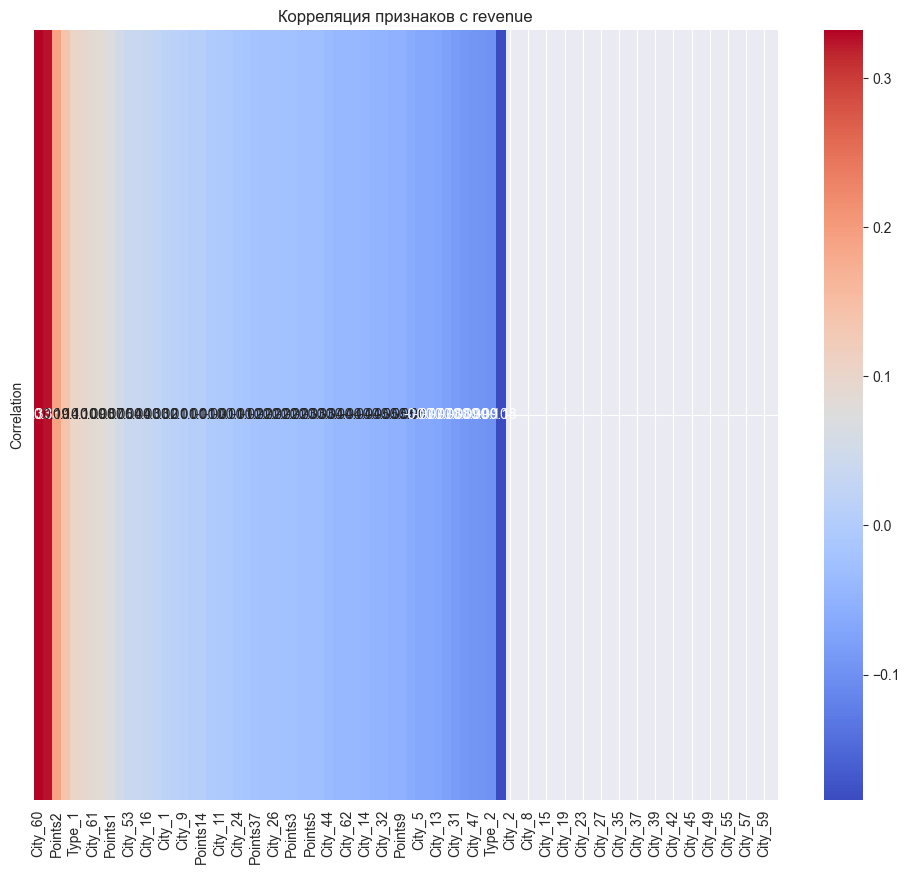

In [75]:
X_all = pd.concat([X_train, X_test])

label_encoder = LabelEncoder()
X_all['City'] = label_encoder.fit_transform(X_all['City'])
X_all['Type'] = label_encoder.fit_transform(X_all['Type'])

X_all = pd.get_dummies(X_all, columns=["City", "Type"])

X_train = X_all[:len(X_train)]
X_test = X_all[len(X_train):]

correlations = X_train.corrwith(data_train['revenue'])
correlations_df = pd.DataFrame({'Correlation': correlations})
correlations_df = correlations_df.sort_values(by='Correlation', ascending=False)
plt.figure(figsize=(12, 10))
sns.heatmap(correlations_df.T, annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Корреляция признаков с revenue")
plt.show()

scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)


In [76]:
model = XGBRegressor(objective='reg:squarederror',
                    n_estimators=1000,
                    max_depth=7,
                    learning_rate=0.04,
                    gamma=0.1)

model.fit(X_train, y_train,  eval_set=[(X_train, y_train)],
          eval_metric='rmse', verbose=True, early_stopping_rounds=7)

evals_result = model.evals_result()

with open('model.pkl', 'wb') as file:
    pickle.dump(model, file)
    
predictions = model.predict(X_test)
predictions = predictions.astype(int)
print(predictions)

[0]	validation_0-rmse:2501750.37954
[1]	validation_0-rmse:2440156.76832
[2]	validation_0-rmse:2381060.70855
[3]	validation_0-rmse:2324323.59214
[4]	validation_0-rmse:2270350.41536
[5]	validation_0-rmse:2218209.48708
[6]	validation_0-rmse:2168299.02070
[7]	validation_0-rmse:2120226.13581
[8]	validation_0-rmse:2074339.16789
[9]	validation_0-rmse:2029006.98208
[10]	validation_0-rmse:1985929.78103
[11]	validation_0-rmse:1944205.63800
[12]	validation_0-rmse:1903449.85258
[13]	validation_0-rmse:1866078.14818
[14]	validation_0-rmse:1827066.94586
[15]	validation_0-rmse:1788056.15525
[16]	validation_0-rmse:1750657.84455
[17]	validation_0-rmse:1717218.11073
[18]	validation_0-rmse:1683152.27875
[19]	validation_0-rmse:1650557.22276
[20]	validation_0-rmse:1619379.98764
[21]	validation_0-rmse:1587175.93224
[22]	validation_0-rmse:1556765.94142
[23]	validation_0-rmse:1529203.75948
[24]	validation_0-rmse:1501120.15969
[25]	validation_0-rmse:1474244.86431
[26]	validation_0-rmse:1449890.38677
[27]	valida

D:\PycharmProjects\softarex-project\.venv\Lib\site-packages\xgboost\sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
D:\PycharmProjects\softarex-project\.venv\Lib\site-packages\xgboost\sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[154]	validation_0-rmse:750370.97012
[155]	validation_0-rmse:750041.29912
[156]	validation_0-rmse:749692.49377
[157]	validation_0-rmse:749405.71736
[158]	validation_0-rmse:749124.49201
[159]	validation_0-rmse:748826.89010
[160]	validation_0-rmse:748619.68677
[161]	validation_0-rmse:748412.53569
[162]	validation_0-rmse:747972.73951
[163]	validation_0-rmse:747542.63947
[164]	validation_0-rmse:747159.35825
[165]	validation_0-rmse:746752.05492
[166]	validation_0-rmse:746399.36159
[167]	validation_0-rmse:746114.25042
[168]	validation_0-rmse:746000.61641
[169]	validation_0-rmse:745896.86844
[170]	validation_0-rmse:745809.91600
[171]	validation_0-rmse:745648.91541
[172]	validation_0-rmse:745330.14162
[173]	validation_0-rmse:745238.14810
[174]	validation_0-rmse:744948.25693
[175]	validation_0-rmse:744853.01110
[176]	validation_0-rmse:744723.45034
[177]	validation_0-rmse:744642.29823
[178]	validation_0-rmse:744515.16825
[179]	validation_0-rmse:744392.55222
[180]	validation_0-rmse:744138.46971
[

Среднеквадратичная ошибка (MSE): 3396747379310.1714
Средняя абсолютная ошибка (MAE): 1146318.2563739999


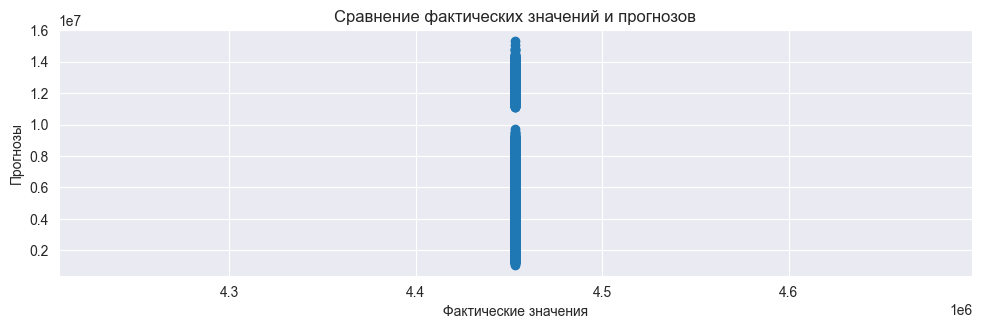

In [77]:
mse = mean_squared_error(y_test, predictions)
mae = mean_absolute_error(y_test, predictions)

print(f"Среднеквадратичная ошибка (MSE): {mse}")
print(f"Средняя абсолютная ошибка (MAE): {mae}")

plt.figure(figsize=(10, 6))
plt.subplot(2, 1, 1)
plt.scatter(y_test, predictions)
plt.xlabel("Фактические значения")
plt.ylabel("Прогнозы")
plt.title("Сравнение фактических значений и прогнозов")

plt.tight_layout()
plt.show()
